<a href="https://colab.research.google.com/github/yumakemore/MedicationEmbedding/blob/master/MedicationEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MedicationEmbedding
Note: You must upload concepts in a csv and events in a csv under the folder icon on the left bar on Colab to run this notebook. 




In [0]:
import pandas as pd
import sys




Read Medication Events (event_csv.csv) into a Pandas DataFrame (event_df);
Read Medication Concepts (concept_csv.csv) into a Pandas DataFrame (concept_df).

In [0]:
import datetime

# Path to the data file
location = input("Enter your csv file name with path or url (e.g., ./medrecords.csv):\n")
#location = r'./event_csv.csv'
# location = 'https://drive.google.com/open?id=1vbZ8LTh7luNR7dmzZk30iKLeWSBkNAk3'

# Parse the data file
event_df = pd.read_csv(location, sep=',', dtype={'encounter':'Int64'})
event_df['start_date']=pd.to_datetime(event_df['start_date'])
event_df['last_modified']=pd.to_datetime(event_df['last_modified'])
event_df['date_recorded']=pd.to_datetime(event_df['date_recorded'])

# Path to the data file
location = r'./concept_csv.csv'
# location = 'https://drive.google.com/open?id=1h9Ok1O740qbz70qLpbmUVX-0Ga5BVt0S'
# Parse the data file
concept_df = pd.read_csv(location, sep=',')
concept_df['start_date']=pd.to_datetime(concept_df['start_date'])
concept_df['end_date']=pd.to_datetime(concept_df['end_date'])

#Check out the data
print("---event_df Schema---\n")
print(event_df.dtypes,"\n")
print("---event_df First 5 Rows---\n")
print(event_df.head(),"\n")
#print(event_df.tail())
print("---concept_df Schema---\n")
print(concept_df.dtypes,"\n")
print("---concept_df First 5 Rows---\n")
print(concept_df.head(),"\n")
#print(concept_df.tail())

---event_df Schema---

unique_id                           int64
name_source                        object
instruction                        object
dose_source                       float64
unit_source                        object
start_date                 datetime64[ns]
Unnamed: 6                         object
status_source                      object
last_modified         datetime64[ns, UTC]
created                            object
data_source                         int64
Unnamed: 11                       float64
user                                int64
Unnamed: 13                        object
route_source                       object
name_clean                         object
Unnamed: 16                       float64
encounter                           Int64
status_mapped                      object
medication_concept                  int64
date_recorded              datetime64[ns]
dtype: object 

---event_df First 5 Rows---

   unique_id                                      

Add standard codes and name from RxNorm through approximate search

In [0]:
import requests
import json

def ApproximateName2RxNorm(approximate_name):
  #e.g., approximate_name="zocor 10 mg"
  name_in_url=approximate_name.replace(' ','%20')
  TermRequest = "https://rxnav.nlm.nih.gov/REST/approximateTerm.json?term="+name_in_url+"&maxEntries=1"

  resp = requests.get(TermRequest)
  if resp.status_code != 200:
      # This means something went wrong.
      raise ApiError('GET /tasks/ {}'.format(resp.status_code))


  #print(resp.text)
  items = resp.json()
  rxcui=[]
  rxcui_approximateTerm_score=[]
  rxcui_attributes_text=[]
  rxcui_attributes_json=[]
  for item in items['approximateGroup']['candidate']:
    #print(item)
    #print(item['rxcui'])
    #print("RxNorm ApproximateTerm Score = ",item['score'])
    rxcui.append(item['rxcui'])
    rxcui_request = "https://rxnav.nlm.nih.gov/REST/rxcui/"+item['rxcui']+"/allProperties.json?prop=all"
    rxcui_resp = requests.get(rxcui_request)
    if rxcui_resp.status_code != 200:
      # This means something went wrong.
      raise ApiError('GET /tasks/ {}'.format(rxcui_resp.status_code))

    #print(rxcui_resp.text, "\n")
    rxcui_attributes_text.append(rxcui_resp.text)
    rxcui_attributes_json.append(rxcui_resp.json())
    rxcui_approximateTerm_score.append(item['score'])

  selected_concept=-1
  for i in range(0,len(rxcui_attributes_json)):
    #print("All Attributes of RxCUI=",rxcui[i],": ",rxcui_attributes_text[i])
    for j in range(0, len(rxcui_attributes_json[i]['propConceptGroup']['propConcept'])):
      #print(rxcui_attributes_json[i]['propConceptGroup']['propConcept'][j]['propName'],"=",
      #      rxcui_attributes_json[i]['propConceptGroup']['propConcept'][j]['propValue'])
      if rxcui_attributes_json[i]['propConceptGroup']['propConcept'][j]['propName']=="NDA":
        selected_concept=i
        break
    if selected_concept != -1: break

  return rxcui_attributes_json[selected_concept], rxcui_approximateTerm_score[selected_concept]
    

In [0]:
import time

waittime=70

print("Before RxNorm: ", event_df.head())
for e_index, e_row in event_df.iterrows():
  Myname = e_row['name_source']
  #print("\n... Wait No. ", e_index, " I am querying RxNorm for ", Myname, " ...\n")
  print(e_index,"/",len(event_df))
  rxdone=0
  while rxdone==0:
    try:
      RxNormData, score =ApproximateName2RxNorm(Myname)
      rxdone=1
    except:
      print("Limit on RxNorm access frequency. Retrial after ", waittime, "sec sleep...")
      time.sleep(waittime)
    
  e_row['RxNorm_score']=score
  for j in range(0, len(RxNormData['propConceptGroup']['propConcept'])):
    #print(RxNormData['propConceptGroup']['propConcept'][j]['propName'],"=",
    #      RxNormData['propConceptGroup']['propConcept'][j]['propValue'])
    e_row[RxNormData['propConceptGroup']['propConcept'][j]['propName']]=RxNormData['propConceptGroup']['propConcept'][j]['propValue']
print("After RxNorm: ", event_df.head())

'''
  for c_index, c_row in concept_df.iterrows():
    if e_row['medication_concept']==c_row['unique_id']:
      #print(str(e_row['name_clean']),str(c_row['name_clean']))
      e_row['fuzzENCtoCNC'] = fuzz.ratio(str(e_row['name_clean']),str(c_row['name_clean']))
      event_df.at[e_index,'fuzzENCtoCNC']=e_row['fuzzENCtoCNC']
      #print(event_df.iloc[[index]].fuzzENCtoCNC)
      if e_row['fuzzENCtoCNC'] != 100:
        #print(e_row['fuzzENCtoCNC'])

        print("EVENT:   ", event_df.iloc[[e_index]][['unique_id','name_source','name_clean','user', 'fuzz', 'fuzzENCtoCNC', 'medication_concept']])
        print("CONCEPT: ", concept_df.iloc[[c_index]][['unique_id','name_clean','user']],"\n")
        #print("===>fuzz<100:","event name_clean",str(e_row['name_clean']),"is mapped to",str(c_row['name_clean']),"\n",sep=" ")
'''

Before RxNorm:     unique_id                                        name_source                                    instruction  dose_source unit_source start_date Unnamed: 6 status_source                    last_modified                        created  data_source  Unnamed: 11  user Unnamed: 13 route_source                                name_clean  Unnamed: 16  encounter status_mapped  medication_concept date_recorded
0        868                               chlorthalidone 25 mg                     1 tablet(s) by mouth daily          1.0      tablet 2018-05-29        NaN     completed 2019-12-05 20:48:34.534068+00:00  2019-11-15 01:53:51.330914+00            1          NaN    62         NaN         oral                            chlorthalidone          NaN        991    NOT TAKING                 338    2019-11-19
1        884                                 atorvastatin 20 mg                     1 tablet(s) by mouth daily          1.0      tablet 2018-03-02        NaN     complete

In [0]:
!pip install fuzzywuzzy
#!pip install fuzzywuzzy[speedup] #python-Levenshtein alternative to the above one
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [0]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', None)

In [0]:


event_df['fuzz']=99
for index, row in event_df.iterrows():
  row['fuzz'] = fuzz.token_set_ratio(str(row['name_source']),str(row['name_clean']))
  event_df.at[index,'fuzz']=row['fuzz']
  #print(event_df.iloc[[index]].fuzz)
  if row['fuzz'] != 100:
    #print(row['fuzz'])
    print(event_df.iloc[[index]][['unique_id','name_source','name_clean','user', 'fuzz']])

In [0]:
# Calculate the fuzz between event's name_clean and the concept's name_clean
event_df['fuzzENCtoCNC']=0
print("\n===== Event name_clean to Concept name_clean Fuzz Test (via medication_concept FK) =====\n")
print("--- Printed below, the event entries with fuzzENCtoCNC less than 100 match ---\n")
for e_index, e_row in event_df.iterrows():
  for c_index, c_row in concept_df.iterrows():
    if e_row['medication_concept']==c_row['unique_id']:
      #print(str(e_row['name_clean']),str(c_row['name_clean']))
      e_row['fuzzENCtoCNC'] = fuzz.ratio(str(e_row['name_clean']),str(c_row['name_clean']))
      event_df.at[e_index,'fuzzENCtoCNC']=e_row['fuzzENCtoCNC']
      #print(event_df.iloc[[index]].fuzzENCtoCNC)
      if e_row['fuzzENCtoCNC'] != 100:
        #print(e_row['fuzzENCtoCNC'])

        print("EVENT:   ", event_df.iloc[[e_index]][['unique_id','name_source','name_clean','user', 'fuzz', 'fuzzENCtoCNC', 'medication_concept']])
        print("CONCEPT: ", concept_df.iloc[[c_index]][['unique_id','name_clean','user']],"\n")
        #print("===>fuzz<100:","event name_clean",str(e_row['name_clean']),"is mapped to",str(c_row['name_clean']),"\n",sep=" ")


In [0]:
'''
merged_df=pd.merge(event_df, concept_df, how='outer',on=['name_clean','user'])
merged_df.to_csv('merged_csv.csv')
'''
check_df=event_df[~event_df.medication_concept.isin(concept_df.unique_id)]
print(check_df) #empty here is good (i.e., all events are mapped to concepts)

# First insight
# try user=62 for examples of <100 fuzz
# user = 63 for clean example of event to concept
# user = 70 for multiple doses to one concept (adderall 3 doses)
# user = 74 for long list ("fat chart")
selected_user=1

print("see the name_clean of index 288:")
selected_events=event_df[event_df.user==selected_user][['user','name_source','name_clean','fuzz','medication_concept']].sort_values('medication_concept')
print(selected_events,"\n")

print("see index 480 (also see 480 and 481 in the concept table):")
selected_concepts=concept_df[concept_df.user==selected_user].sort_values('unique_id')
#print(concept_df[concept_df.user==selected_user][['name_clean', 'unique_id']].sort_values('unique_id'),"\n")
print(selected_concepts,"\n")

'''
event_df_grp_by_user=event_df.groupby(by='user')
print(event_df_grp_by_user['name_source','name_clean'].nunique(),"\n")
print(event_df_grp_by_user.head(),"\n")
concept_df_grp_by_user=concept_df.groupby(by='user')
print(concept_df_grp_by_user['name_clean'].nunique(),"\n")
print(concept_df_grp_by_user.head(),"\n")
'''



# Word/Name Embedding to capture the concepts co-occurrance as vector similarity

In [0]:
import re

concept_df_sort_by_user=concept_df.sort_values(['user','start_date'])
concept_df_sort_by_user=concept_df_sort_by_user.reset_index(drop=True)
#print (concept_df_sort_by_user.head(100))
for index, row in concept_df_sort_by_user.iterrows():
  '''
  optional: name level
  concept_df_sort_by_user.at[index,'name_clean']=re.sub('[\s,-,\/,\[,\],(,),\,]', '-', concept_df_sort_by_user.at[index,'name_clean'])
  concept_df_sort_by_user.at[index,'name_clean']=re.sub('[\s,-]+', '-', concept_df_sort_by_user.at[index,'name_clean'])
  concept_df_sort_by_user.at[index,'name_clean']=re.sub('\A-*', '', concept_df_sort_by_user.at[index,'name_clean'])
  concept_df_sort_by_user.at[index,'name_clean']=re.sub('-*\B', '', concept_df_sort_by_user.at[index,'name_clean'])
  '''
  '''
  # optional: word level
  concept_df_sort_by_user.at[index,'name_clean']=re.sub('[-,\/,\[,\],(,),\,]', ' ', concept_df_sort_by_user.at[index,'name_clean'])
  concept_df_sort_by_user.at[index,'name_clean']=re.sub('\A\s*', '', concept_df_sort_by_user.at[index,'name_clean'])
  concept_df_sort_by_user.at[index,'name_clean']=re.sub('\s*\B', '', concept_df_sort_by_user.at[index,'name_clean'])
  concept_df_sort_by_user.at[index,'name_clean']=re.sub('\s+', ' ', concept_df_sort_by_user.at[index,'name_clean'])
  '''

  try:
    #print(concept_df_sort_by_user.at[index,'user'],"\n")
    #print("===",concept_df_sort_by_user.at[index-1,'user'],"\n")
    if concept_df_sort_by_user.at[index,'user'] != concept_df_sort_by_user.at[index-1,'user']:
      concept_df_sort_by_user.at[index-1,'name_clean']= str(concept_df_sort_by_user.at[index-1,'name_clean'])+"\n"
      #print(concept_df_sort_by_user.iloc[index-1],"\n")
      #print(event_df.iloc[[index]][['unique_id','name_source','name_clean','user', 'fuzz']])

  except:
      continue

concept_text=str(concept_df_sort_by_user['name_clean'].str.cat(sep=' '))
concept_text=re.sub('\n\s+', '\n', concept_text)

print(concept_text)

f = open("./concept_name_clean.txt", "w")
f.write(concept_text)
f.close()

diazepam topiramate (TOPAMAX) carbamazepine misoprostol MIRENA (52 MG) (IBUPROFEN) ULTRASOUND - LIVER, GALLBLADDER (OMEPRAZOLE) TRANSVAGINAL AND TRANSABDOMINAL PELVIC ULTRASOUND (IBUPROFEN)
topiramate (TOPAMAX) diazepam carbamazepine misoprostol MIRENA (52 MG) ISONIAZID IBUPROFEN OMEPRAZOLE ULTRASOUND - LIVER, GALLBLADDER TRANSVAGINAL AND TRANSABDOMINAL PELVIC ULTRASOUND
riboflavin, vitamin B Coenzyme Q topiramate naproxen sodium (ANAPROX DS) SUMAtriptan (IMITREX) clarithromycin Magnesium Multivitamin Etonogestrel - Ethinyl Estradiol (NUVARING) Acyclovir (ZOVIRAX) predniSONE Naproxen (NAPROSYN) Cyclobenzaprine (FLEXERIL) Acetaminophen (TYLENOL) Cephalexin (KEFLEX) Fluconazole (DIFLUCAN) Cefpodoxime (VANTIN) Ondansetron (ZOFRAN ODT) Maxalt aspirin-acetaminophen-caffeine (EXCEDRIN MIGRAINE) albuterol (PROAIR HFA) calcium carbonate vitamin B complex-vitamin C (VITAMIN B COMPLEX WITH C)
CLINDAMYCIN PHOSPHATE,TOPICAL, Norethin Ace-Eth Estrad-FE (GILDESS FE Amoxicillin Albuterol Sulfate 108 

# Neural Network Preparation

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

In [0]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
#--- Load Data from concept_name_clean.txt
def labeler(example, index):
  return example, tf.cast(index, tf.int64)
labeled_data_sets = []
lines_dataset = tf.data.TextLineDataset('./concept_name_clean.txt')
labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 0))
labeled_data_sets.append(labeled_dataset)


In [0]:
BUFFER_SIZE = 500
BATCH_SIZE = 4
TAKE_SIZE = 10

all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
  
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

for ex in all_labeled_data.take(5):
  print(ex)


(<tf.Tensor: shape=(), dtype=string, numpy=b'topiramate (TOPAMAX) diazepam carbamazepine misoprostol MIRENA (52 MG) ISONIAZID IBUPROFEN OMEPRAZOLE ULTRASOUND - LIVER, GALLBLADDER TRANSVAGINAL AND TRANSABDOMINAL PELVIC ULTRASOUND'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'levonorgestrel (MIRENA) ibuprofen (ADVIL;MOTRIN)'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'CLINDAMYCIN PHOSPHATE,TOPICAL, Norethin Ace-Eth Estrad-FE (GILDESS FE Amoxicillin Albuterol Sulfate 108 (90 BASE) Doxycycline Hyclate Tretinoin AcetaZOLAMIDE'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Ketoconazole Typhoid Vaccine Azithromycin Atovaquone-Proguanil 250 Mg-100 Mg Tab (Atovaquone/Proguanil Hcl)'>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'erythromycin OP ophthalmic ointment triamcinolone acetonide (KENALOG) Norethin Ace-E

In [0]:
tokenizer = tfds.features.text.Tokenizer()

vocabulary_set = set()
for text_tensor, _ in all_labeled_data:
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size

288

In [0]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)
example_text = next(iter(all_labeled_data))[0].numpy()
print(example_text)
encoded_example = encoder.encode(example_text)
print(encoded_example)

b'topiramate (TOPAMAX) diazepam carbamazepine misoprostol MIRENA (52 MG) ISONIAZID IBUPROFEN OMEPRAZOLE ULTRASOUND - LIVER, GALLBLADDER TRANSVAGINAL AND TRANSABDOMINAL PELVIC ULTRASOUND'
[126, 167, 41, 166, 183, 267, 100, 28, 85, 147, 276, 150, 206, 175, 104, 211, 42, 176, 150]


In [0]:
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label


In [0]:
def encode_map_fn(text, label):
  # py_func doesn't set the shape of the returned tensors.
  encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int64))

  # `tf.data.Datasets` work best if all components have a shape set
  #  so set the shapes manually: 
  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label


all_encoded_data = all_labeled_data.map(encode_map_fn)

In [0]:
train_data = all_encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE)

test_data = all_encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE)

try:
  print (next(iter(train_data)))
except:
  print("End of dataset")  # ==> "End of dataset"
print (next(iter(test_data)))

(<tf.Tensor: shape=(4, 11), dtype=int64, numpy=
array([[245,  73, 191, 136, 216, 254, 233,  15,  94,  62, 146],
       [278,  61,  49, 177, 288,  77, 119,   0,   0,   0,   0],
       [189,  63,   3, 201,   0,   0,   0,   0,   0,   0,   0],
       [280,  74, 134, 234,  74, 222,  70,  55, 134, 179,  46]])>, <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 0])>)
(<tf.Tensor: shape=(4, 20), dtype=int64, numpy=
array([[126, 167,  41, 166, 183, 267, 100,  28,  85, 147, 276, 150, 206,
        175, 104, 211,  42, 176, 150,   0],
       [219, 267, 284, 285,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [163, 200, 218, 220, 255,   9, 144, 237, 171, 237, 274,  18, 145,
        268, 178, 149, 269, 229,  79, 196],
       [ 58, 247, 241, 160,  48,  54, 192, 217, 228, 217,  95,  48,  54,
        148,   0,   0,   0,   0,   0,   0]])>, <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 0])>)


In [0]:
sample_text, sample_labels = next(iter(test_data))

print (sample_text[0], "\n", sample_labels[0], "\n\n")
print (sample_text[1], "\n", sample_labels[1])

tf.Tensor(
[126 167  41 166 183 267 100  28  85 147 276 150 206 175 104 211  42 176
 150   0], shape=(20,), dtype=int64) 
 tf.Tensor(0, shape=(), dtype=int64) 


tf.Tensor(
[219 267 284 285   1   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(20,), dtype=int64) 
 tf.Tensor(0, shape=(), dtype=int64)


In [0]:
vocab_size += 1

# LSTM Model

In [0]:
embedding_dim=16
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)))
# One or more dense layers.
# Edit the list in the `for` line to experiment with layer sizes.
for units in [embedding_dim, embedding_dim]:
  model.add(tf.keras.layers.Dense(units, activation='relu'))

# Output layer. The first argument is the number of labels.
model.add(tf.keras.layers.Dense(3))

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          4624      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 51        
Total params: 9,699
Trainable params: 9,699
Non-trainable params: 0
_________________________________________________________________


In [0]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    #train_batches,
    train_data,
    epochs=100,
    #validation_data=test_batches, validation_steps=20)
    validation_data=test_data)

Epoch 1/100
5/5 [==============================] - 1s 138ms/step - loss: 1.0962 - accuracy: 0.6111 - val_loss: 1.0784 - val_accuracy: 1.0000
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 1.0685 - accuracy: 1.0000 - val_loss: 1.0495 - val_accuracy: 1.0000
Epoch 3/100
5/5 [==============================] - 0s 16ms/step - loss: 1.0359 - accuracy: 1.0000 - val_loss: 1.0130 - val_accuracy: 1.0000
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 0.9934 - accuracy: 1.0000 - val_loss: 0.9643 - val_accuracy: 1.0000
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 0.9347 - accuracy: 1.0000 - val_loss: 0.8962 - val_accuracy: 1.0000
Epoch 6/100
5/5 [==============================] - 0s 18ms/step - loss: 0.8593 - accuracy: 1.0000 - val_loss: 0.7967 - val_accuracy: 1.0000
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 0.7474 - accuracy: 1.0000 - val_loss: 0.6462 - val_accuracy: 1.0000
Epoch 8/100
5/5 [==

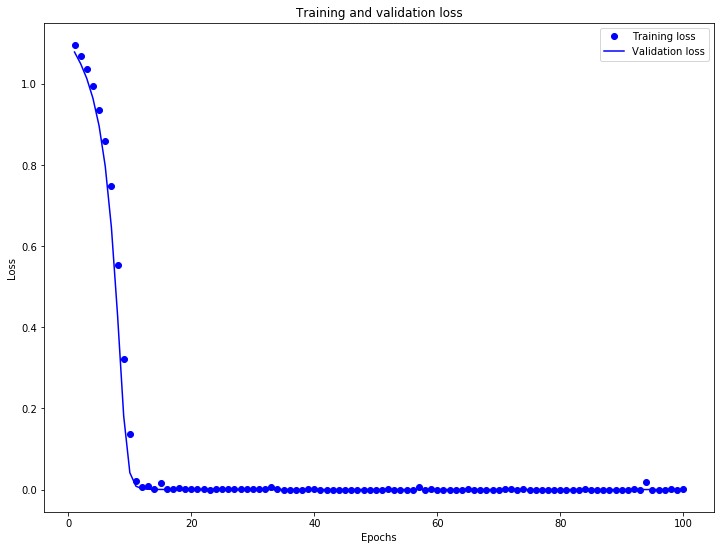

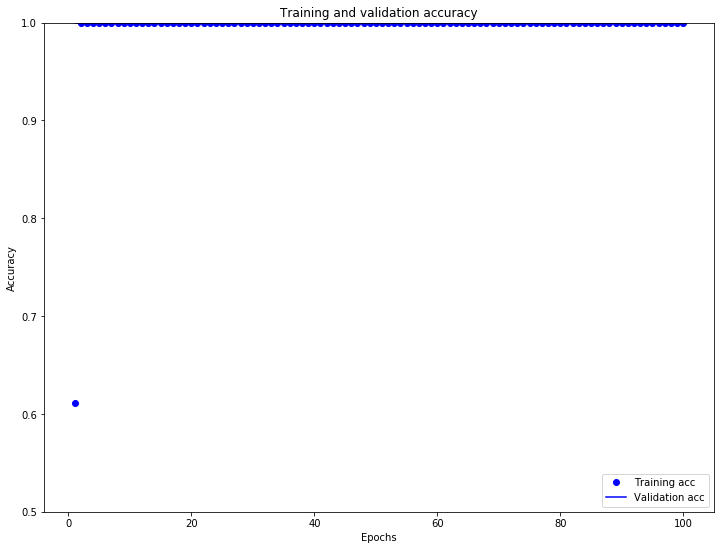

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [0]:
eval_loss, eval_acc = model.evaluate(test_data)

print('\nEval loss: {:.12f}, Eval accuracy: {:.12f}'.format(eval_loss, eval_acc))


3/3 [==============================] - 0s 6ms/step - loss: 3.7750e-07 - accuracy: 1.0000

Eval loss: 0.000000377496, Eval accuracy: 1.000000000000


In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(289, 16)


In [0]:
print (vocabulary_set)

{'MOTRIN', 'VANTIN', 'estradiol', 'clindamycin', 'Isotretinoin', 'b', 'PROAIR', 'Norethindrone', 'Eth', 'Q', 'lidocaine', 'Etonogestrel', 'SR', 'pantoprazole', 'IUD', 'micronized', 'acetaminophen', 'Albuterol', 'JUNEL', 'Acyclovir', 'ENPRESSE', 'mg', 'fluticasone', 'ROXICODONE', 'Hydrochloride', 'Naproxen', 'ranitidine', 'MG', 'KEFLEX', 'ZOFRAN', 'cyclobenzaprine', 'PARAGARD', 'azithromycin', 'CYMBALTA', 'montelukast', 'HYDROCORTISONE', 'clomiPHENE', 'ODT', 'Oxymetazoline', 'DELTASONE', 'diazepam', 'TRANSABDOMINAL', 'Gatifloxacin', 'tablet', 'nitrofurantoin', 'XR', 'Coenzyme', 'Atovaquone', 'amphetamine', 'codeine', 'Spironolactone', 'SUMAtriptan', 'riboflavin', 'Proguanil', 'Dextroamphet', 'sodium', 'naproxen', 'Ketoconazole', 'naloxone', 'PRILOSEC', 'dextroamphetamine', 'Complex', 'ethinyl', 'DULoxetine', 'chloride', 'Fluconazole', 'D3', 'acetonide', 'Ketorolac', 'Amphetamine', 'COMPLEX', 'calcium', 'Z', 'HCl', 'loratadine', 'ACYCLOVIR', 'Macrobid', 'Clindamycin', 'Tretinoin', 'omega

In [0]:
import io

#encoder = info.features['text'].encoder

out_v = io.open('vecs_LSTM.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_LSTM.tsv', 'w', encoding='utf-8')

#for num, word in enumerate(encoder.subwords):
for num, word in enumerate(vocabulary_set):
  print (num, "\n", word)
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

0 
 MOTRIN
1 
 VANTIN
2 
 estradiol
3 
 clindamycin
4 
 Isotretinoin
5 
 b
6 
 PROAIR
7 
 Norethindrone
8 
 Eth
9 
 Q
10 
 lidocaine
11 
 Etonogestrel
12 
 SR
13 
 pantoprazole
14 
 IUD
15 
 micronized
16 
 acetaminophen
17 
 Albuterol
18 
 JUNEL
19 
 Acyclovir
20 
 ENPRESSE
21 
 mg
22 
 fluticasone
23 
 ROXICODONE
24 
 Hydrochloride
25 
 Naproxen
26 
 ranitidine
27 
 MG
28 
 KEFLEX
29 
 ZOFRAN
30 
 cyclobenzaprine
31 
 PARAGARD
32 
 azithromycin
33 
 CYMBALTA
34 
 montelukast
35 
 HYDROCORTISONE
36 
 clomiPHENE
37 
 ODT
38 
 Oxymetazoline
39 
 DELTASONE
40 
 diazepam
41 
 TRANSABDOMINAL
42 
 Gatifloxacin
43 
 tablet
44 
 nitrofurantoin
45 
 XR
46 
 Coenzyme
47 
 Atovaquone
48 
 amphetamine
49 
 codeine
50 
 Spironolactone
51 
 SUMAtriptan
52 
 riboflavin
53 
 Proguanil
54 
 Dextroamphet
55 
 sodium
56 
 naproxen
57 
 Ketoconazole
58 
 naloxone
59 
 PRILOSEC
60 
 dextroamphetamine
61 
 Complex
62 
 ethinyl
63 
 DULoxetine
64 
 chloride
65 
 Fluconazole
66 
 D3
67 
 acetonide
68 
 Ketor

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs_LSTM.tsv')
  files.download('meta_LSTM.tsv')

Visualize the embeddings

To visualize our embeddings we will upload them to the embedding projector.
Open the Embedding Projector (http://projector.tensorflow.org).
Click on "Load data". Upload the two files we created above: vecs_LSTM.tsv and meta_LSTM.tsv. The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".


# Alternative: Pooling instead of LSTM (lower performance)


In [0]:
embedding_layer = layers.Embedding(100, 5)

In [0]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

In [0]:
train_batches = train_data.shuffle(100).padded_batch(10)
test_batches = test_data.shuffle(100).padded_batch(10)

In [0]:
train_batch, train_labels = next(iter(train_batches))
print (train_batch, "\n\n",train_labels,"\n")
train_batch.numpy()

tf.Tensor(
[[[245  73 191 ...   0   0   0]
  [155 184   3 ...   0   0   0]
  [ 32 275 197 ...   0   0   0]
  [ 41 126 167 ...   0   0   0]]

 [[280  74 134 ...   0   0   0]
  [153  17 130 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]]

 [[216  96 158 ...   0   0   0]
  [257 261 230 ...   0   0   0]
  [278  61  49 ...   0   0   0]
  [ 12 281 235 ...   0   0   0]]

 [[199  60 113 ...   0   0   0]
  [ 49  61 179 ...   0   0   0]
  [189  63   3 ...   0   0   0]
  [219  63   3 ...   0   0   0]]

 [[280  74 134 ...   0   0   0]
  [ 36  90  37 ...   0   0   0]
  [ 27 189  63 ...   0   0   0]
  [ 53 195  94 ...  71 117 132]]], shape=(5, 4, 58), dtype=int64) 

 tf.Tensor(
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]], shape=(5, 4), dtype=int64) 



array([[[245,  73, 191, ...,   0,   0,   0],
        [155, 184,   3, ...,   0,   0,   0],
        [ 32, 275, 197, ...,   0,   0,   0],
        [ 41, 126, 167, ...,   0,   0,   0]],

       [[280,  74, 134, ...,   0,   0,   0],
        [153,  17, 130, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[216,  96, 158, ...,   0,   0,   0],
        [257, 261, 230, ...,   0,   0,   0],
        [278,  61,  49, ...,   0,   0,   0],
        [ 12, 281, 235, ...,   0,   0,   0]],

       [[199,  60, 113, ...,   0,   0,   0],
        [ 49,  61, 179, ...,   0,   0,   0],
        [189,  63,   3, ...,   0,   0,   0],
        [219,  63,   3, ...,   0,   0,   0]],

       [[280,  74, 134, ...,   0,   0,   0],
        [ 36,  90,  37, ...,   0,   0,   0],
        [ 27, 189,  63, ...,   0,   0,   0],
        [ 53, 195,  94, ...,  71, 117, 132]]])

In [0]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          4640      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    #train_batches,
    train_data,
    epochs=100,
    #validation_data=test_batches, validation_steps=20)
    validation_data=test_data)

Epoch 1/100
5/5 [==============================] - 0s 22ms/step - loss: 0.6874 - accuracy: 1.0000 - val_loss: 0.6811 - val_accuracy: 1.0000
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 0.6761 - accuracy: 1.0000 - val_loss: 0.6688 - val_accuracy: 1.0000
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 0.6627 - accuracy: 1.0000 - val_loss: 0.6551 - val_accuracy: 1.0000
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.6470 - accuracy: 1.0000 - val_loss: 0.6397 - val_accuracy: 1.0000
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 0.6311 - accuracy: 1.0000 - val_loss: 0.6230 - val_accuracy: 1.0000
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.6097 - accuracy: 1.0000 - val_loss: 0.6059 - val_accuracy: 1.0000
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 0.5881 - accuracy: 1.0000 - val_loss: 0.5881 - val_accuracy: 1.0000
Epoch 8/100
5/5 [=========

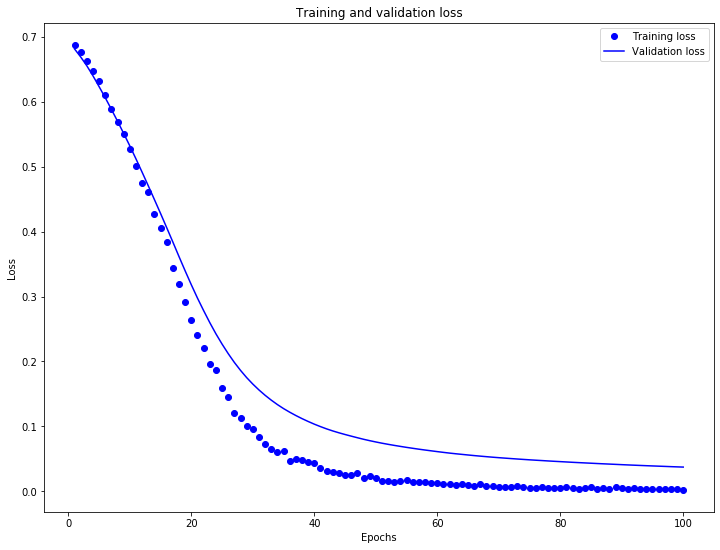

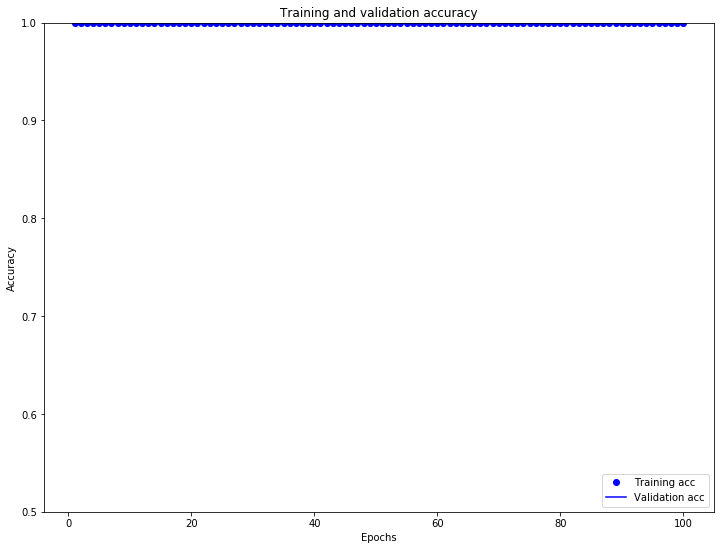

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(290, 16)


In [0]:
print (vocabulary_set)

{'MOTRIN', 'VANTIN', 'estradiol', 'clindamycin', 'Isotretinoin', 'b', 'PROAIR', 'Norethindrone', 'Eth', 'Q', 'lidocaine', 'Etonogestrel', 'SR', 'pantoprazole', 'IUD', 'micronized', 'acetaminophen', 'Albuterol', 'JUNEL', 'Acyclovir', 'ENPRESSE', 'mg', 'fluticasone', 'ROXICODONE', 'Hydrochloride', 'Naproxen', 'ranitidine', 'MG', 'KEFLEX', 'ZOFRAN', 'cyclobenzaprine', 'PARAGARD', 'azithromycin', 'CYMBALTA', 'montelukast', 'HYDROCORTISONE', 'clomiPHENE', 'ODT', 'Oxymetazoline', 'DELTASONE', 'diazepam', 'TRANSABDOMINAL', 'Gatifloxacin', 'tablet', 'nitrofurantoin', 'XR', 'Coenzyme', 'Atovaquone', 'amphetamine', 'codeine', 'Spironolactone', 'SUMAtriptan', 'riboflavin', 'Proguanil', 'Dextroamphet', 'sodium', 'naproxen', 'Ketoconazole', 'naloxone', 'PRILOSEC', 'dextroamphetamine', 'Complex', 'ethinyl', 'DULoxetine', 'chloride', 'Fluconazole', 'D3', 'acetonide', 'Ketorolac', 'Amphetamine', 'COMPLEX', 'calcium', 'Z', 'HCl', 'loratadine', 'ACYCLOVIR', 'Macrobid', 'Clindamycin', 'Tretinoin', 'omega

In [0]:
import io

#encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

#for num, word in enumerate(encoder.subwords):
for num, word in enumerate(vocabulary_set):
  print (num, "\n", word)
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

0 
 MOTRIN
1 
 VANTIN
2 
 estradiol
3 
 clindamycin
4 
 Isotretinoin
5 
 b
6 
 PROAIR
7 
 Norethindrone
8 
 Eth
9 
 Q
10 
 lidocaine
11 
 Etonogestrel
12 
 SR
13 
 pantoprazole
14 
 IUD
15 
 micronized
16 
 acetaminophen
17 
 Albuterol
18 
 JUNEL
19 
 Acyclovir
20 
 ENPRESSE
21 
 mg
22 
 fluticasone
23 
 ROXICODONE
24 
 Hydrochloride
25 
 Naproxen
26 
 ranitidine
27 
 MG
28 
 KEFLEX
29 
 ZOFRAN
30 
 cyclobenzaprine
31 
 PARAGARD
32 
 azithromycin
33 
 CYMBALTA
34 
 montelukast
35 
 HYDROCORTISONE
36 
 clomiPHENE
37 
 ODT
38 
 Oxymetazoline
39 
 DELTASONE
40 
 diazepam
41 
 TRANSABDOMINAL
42 
 Gatifloxacin
43 
 tablet
44 
 nitrofurantoin
45 
 XR
46 
 Coenzyme
47 
 Atovaquone
48 
 amphetamine
49 
 codeine
50 
 Spironolactone
51 
 SUMAtriptan
52 
 riboflavin
53 
 Proguanil
54 
 Dextroamphet
55 
 sodium
56 
 naproxen
57 
 Ketoconazole
58 
 naloxone
59 
 PRILOSEC
60 
 dextroamphetamine
61 
 Complex
62 
 ethinyl
63 
 DULoxetine
64 
 chloride
65 
 Fluconazole
66 
 D3
67 
 acetonide
68 
 Ketor

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

# Visualize the embeddings
To visualize our embeddings we will upload them to the embedding projector.

Open the Embedding Projector (http://projector.tensorflow.org).

Click on "Load data".
Upload the two files we created above: vecs.tsv and meta.tsv.
The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".

![alt text](https://)